# Bank marketing campaign analysis

The code analyzes the marketing campaign data of a Portugeuse bank and aims to predict whether the customer will subscribe to fixed-term deposit product offered by the bank. The code cleans the data, imputes the missing values, selects features and  compares data mining models.

### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer
from sklearn.metrics import roc_curve,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [459]:
pd.set_option('display.max_columns', 50)

### Load dataset

In [26]:
bank=pd.read_csv('bank-additional-full.csv', delimiter=';')

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

#### check for null values

In [623]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Visualize the categorical features

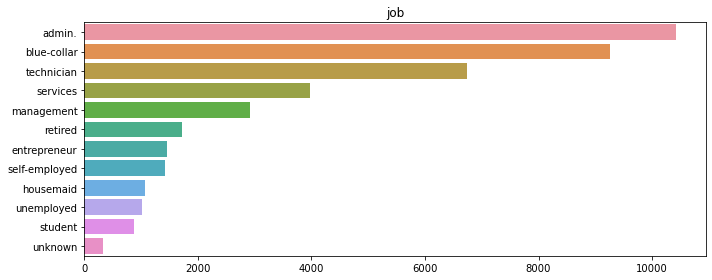

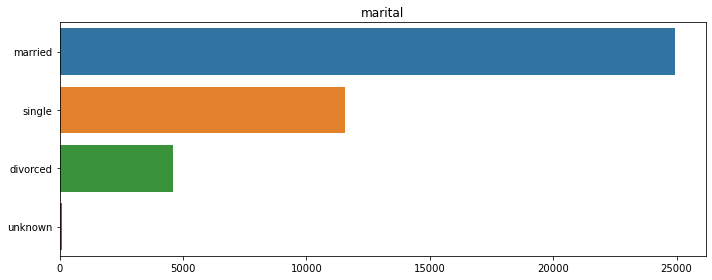

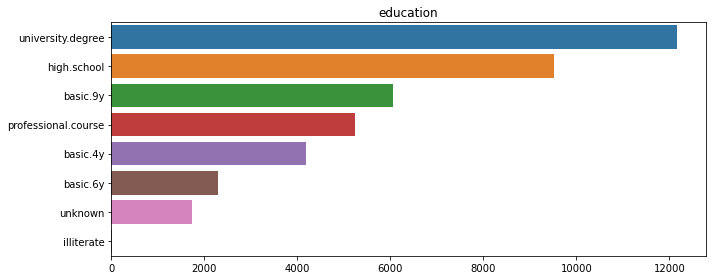

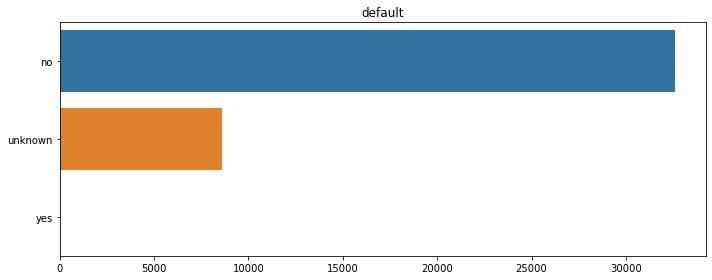

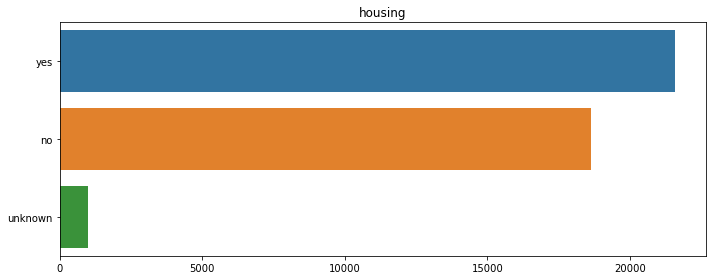

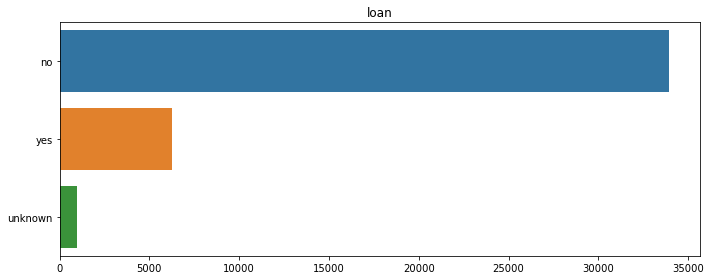

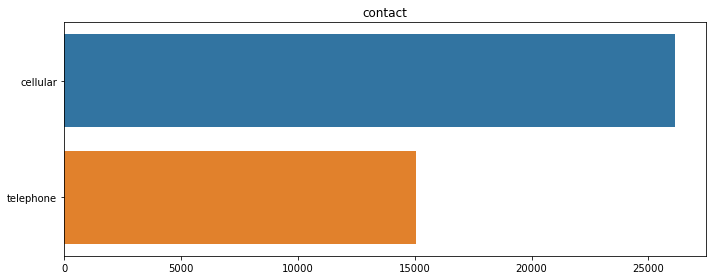

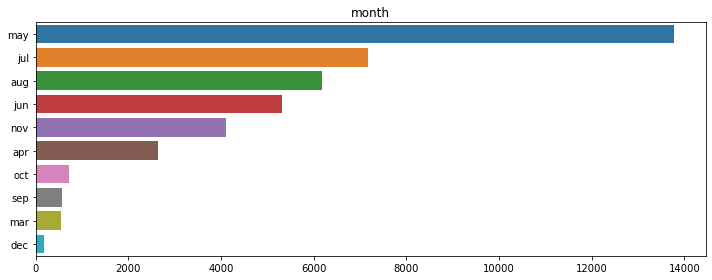

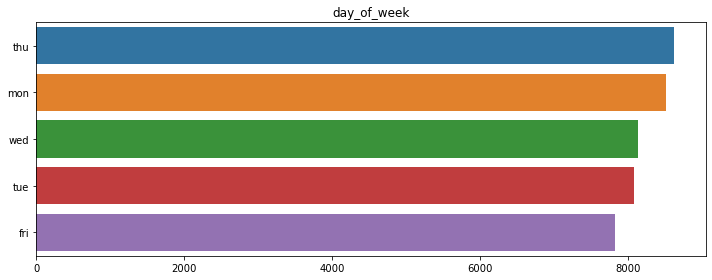

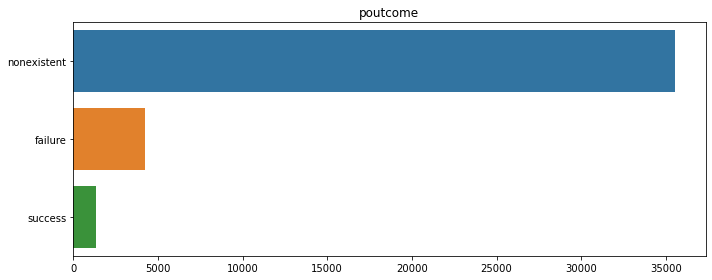

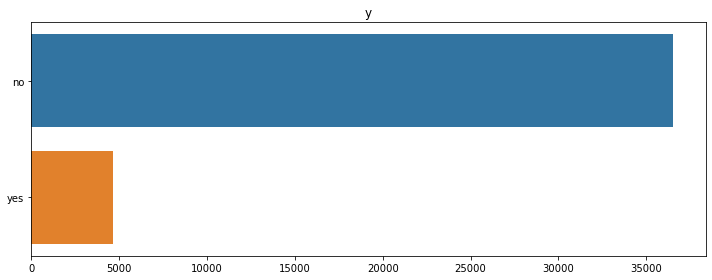

In [622]:
categorcial_cols = ['job', 'marital', 'education', 'default', 'housing','loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_cols:
    plt.figure(figsize=(10,4))
    sns.barplot(bank[col].value_counts().values, bank[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

Since duration attribute highly affects the target variable as when duration is 0, y='no'  and after the call, y is known. So we eliminate the feature for realistic predictions. Also, most of the values in default feature have unknown values sothat needs to be removed as well

In [27]:
bank=bank.drop(['duration'],axis=1)

The education feature has 3 different categories for basic. We can combine these three categories to one to reduce the number of features

In [624]:
bank.replace(['basic.6y','basic.4y', 'basic.9y'], 'basic', inplace=True)

### Explore numerical variables

In [9]:
bank.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


We can see that the maximum value for age is 98 that could be an outlier, but we cannot tell for sure. So the value is kept.
Additionally, pdays or number of days that passed by after the client was previous contacted has maximum value of 999. Since if from the data source, we know that if the client has not been contacted, the value is 999 for that instance

(array([ 1515.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 39673.]),
 array([  0. ,  99.9, 199.8, 299.7, 399.6, 499.5, 599.4, 699.3, 799.2,
        899.1, 999. ]),
 <BarContainer object of 10 artists>)

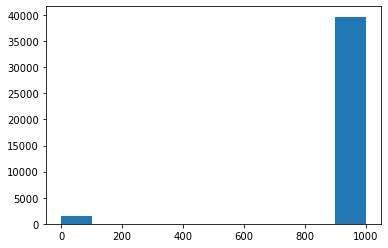

In [162]:
plt.hist(bank['pdays'])

We can see that most values are 999.

In [163]:
bank.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

So, we can convert the feature into binary 

In [28]:
bank['pdays'] = [0 if x == 999 else 1 for x in bank['pdays']]

In [8]:
bank.pdays.value_counts()

0    39673
1     1515
Name: pdays, dtype: int64

#### Convert target to binary 

In [29]:
bank = bank.rename(columns={'y': 'target'})
bank['target'] = bank['target'].map({'no': 0, 'yes': 1})

#### Explore cross-tabulations

Text(0, 0.5, 'Frequency of Purchase')

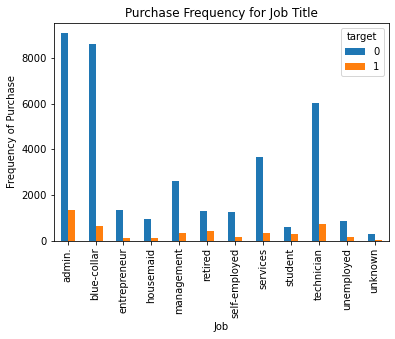

In [626]:
pd.crosstab(bank.job,bank.target).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

<Figure size 720x720 with 0 Axes>

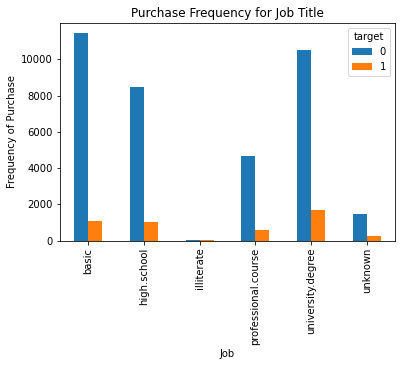

<Figure size 720x720 with 0 Axes>

In [629]:
pd.crosstab(bank.education,bank.target).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.figure(figsize=(10,10))
# plt.savefig('img/purchase_fre_job')

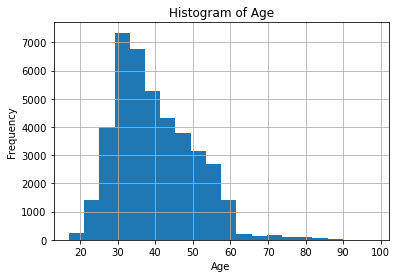

In [632]:
bank.age.hist(bins=20)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');
# plt.savefig('hist_age')

In [695]:
age_crosstab=pd.crosstab(bank.age,bank.target).reset_index()

In [696]:
age_crosstab.loc[(age_crosstab['age']<=25), 'age']= 0
age_crosstab.loc[(age_crosstab['age']>25) & (age_crosstab['age']<=35), 'age']=1
age_crosstab.loc[(age_crosstab['age']>35) & (age_crosstab['age']<=45), 'age']=2
age_crosstab.loc[(age_crosstab['age']>45) & (age_crosstab['age']<=60), 'age']=3
age_crosstab.loc[(age_crosstab['age']>60), 'age']=4

In [697]:
age_crosstab.loc[(age_crosstab['age']==0),'age']= 'Less than 25'
age_crosstab.loc[(age_crosstab['age']==1),'age']='25-35'
age_crosstab.loc[(age_crosstab['age']==2),'age']='35-45'
age_crosstab.loc[(age_crosstab['age']==3),'age']='45-60'
age_crosstab.loc[(age_crosstab['age']==4),'age']='Above 60'

<AxesSubplot:xlabel='age'>

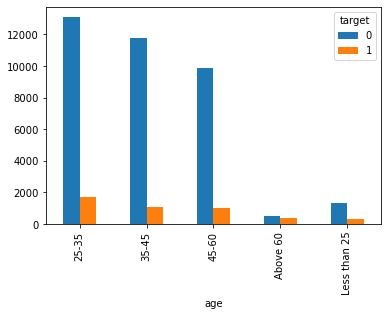

In [690]:
age_crosstab.groupby('age')[[0,1]].sum().plot(kind='bar')

We can see that the ratio of contact to subscription is highest for above 60 age group

### Imputation of 'unknown'

In [7]:
bank[bank.apply(lambda row: row.astype(str).str.contains('unknown').any(), axis=1)].shape

(10700, 20)

In [32]:
bank_imp=bank.copy()

Find Job distribution by age

In [9]:
bank_imp['job'][bank_imp['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

We can see that majority of above 60 clients are retired

In [33]:
bank_imp.loc[(bank_imp['age']>60) & (bank_imp['job']=='unknown'), 'job'] = 'retired'

In [11]:
def impute(df,c1,c2):
    """ Function to study the distribution of job by education"""
    ed=list(df[c2].unique())
    df_list=[]
    for e in ed:
        df_e=df[df[c2]==e]
        df_job=df_e.groupby(c1).count()[c2]
        df_list.append(df_job)
    df_new=pd.concat(df_list,axis=1)
    df_new.columns=ed
    df_new=df_new.fillna(0)
    return df_new

In [12]:
impute(bank_imp,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,601,276,75,145,243,112,286,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


We can see that most blue-collar clients have 'basic' education, so we can impute unknown values accordingly. Similarly, most management jobs need university degree. The imputations are therefore done based on the above observation as well based on real world knowledge

In [34]:
bank_imp.loc[(bank_imp['education']=='unknown') & (bank_imp['job']=='management'), 'education'] = 'university.degree'
bank_imp.loc[(bank_imp['education']=='unknown') & (bank_imp['job']=='services'), 'education'] = 'high.school'
bank_imp.loc[(bank_imp['education']=='unknown') & (bank_imp['job']=='housemaid'), 'education'] = 'basic.4y'
bank_imp.loc[(bank_imp['education']=='unknown') & (bank_imp['job']=='blue-collar'), 'education'] = 'basic.4y'
bank_imp.loc[(bank_imp['job'] == 'unknown') & (bank_imp['education']=='basic.4y'), 'job'] = 'blue-collar'
bank_imp.loc[(bank_imp['job']=='unknown') & (bank_imp['education']=='professional.course'), 'job'] = 'technician'

In [16]:
impute(bank_imp,'job','education')

,basic,high.school,professional.course,university.degree,unknown,illiterate
admin.,727.0,3329,363.0,5753,249.0,1.0
blue-collar,7922.0,878,453.0,94,0.0,8.0
entrepreneur,418.0,234,135.0,610,57.0,2.0
housemaid,687.0,174,59.0,139,0.0,1.0
management,351.0,298,89.0,2186,0.0,0.0
retired,821.0,276,243.0,286,112.0,3.0
self-employed,338.0,118,168.0,765,29.0,3.0
services,746.0,2832,218.0,173,0.0,0.0
student,138.0,357,43.0,170,167.0,0.0
technician,529.0,873,3330.0,1809,212.0,0.0


Since no  more imputations are possible, we drop the rest of the rows with unknown values

In [24]:
bank_imp = bank_imp.replace({'unknown': np.nan}).dropna()

In [25]:
bank_imp.shape

(31014, 20)

In [35]:
bank_i=pd.get_dummies(bank_imp,columns=['marital','job','education','housing','loan','poutcome','contact','month','day_of_week','default'],drop_first=True)

In [36]:
X=bank_i.drop('target',axis=1)
y=bank_i['target']

Now, we scale our data and split it in to test and training set

In [37]:
def split_test_train(data,scaled=True):
    
    """ function to split the data in to test and train and scale the data"""
    X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.3,random_state=1,stratify=y)
    if scaled:
        minmaxscaler = MinMaxScaler(feature_range = (0,1))

        minmaxscaler.fit(X_train)
        X_train = minmaxscaler.transform(X_train)
        X_test = minmaxscaler.transform(X_test)
        
    
    return X_train,X_test,y_train,y_test

In [38]:
X_train,X_test,y_train,y_test=split_test_train(X)

### Oversampling

In order to help with the data imbalance, we use oversampling to balance the target classes. We use SMOTE for this purpose

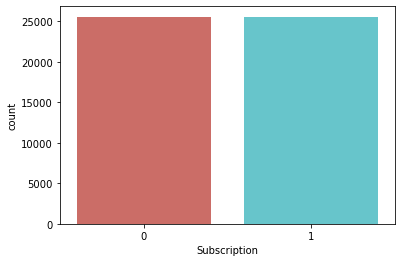

In [39]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=1)
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

c=sns.countplot(x=os_data_y, palette='hls')
plt.xlabel('Subscription')
c.set_xticklabels(['0','1']);


### Feature Selection

#### Study the correlation

In [711]:
corr_matrix=bank_i.corr().abs()

<AxesSubplot:>

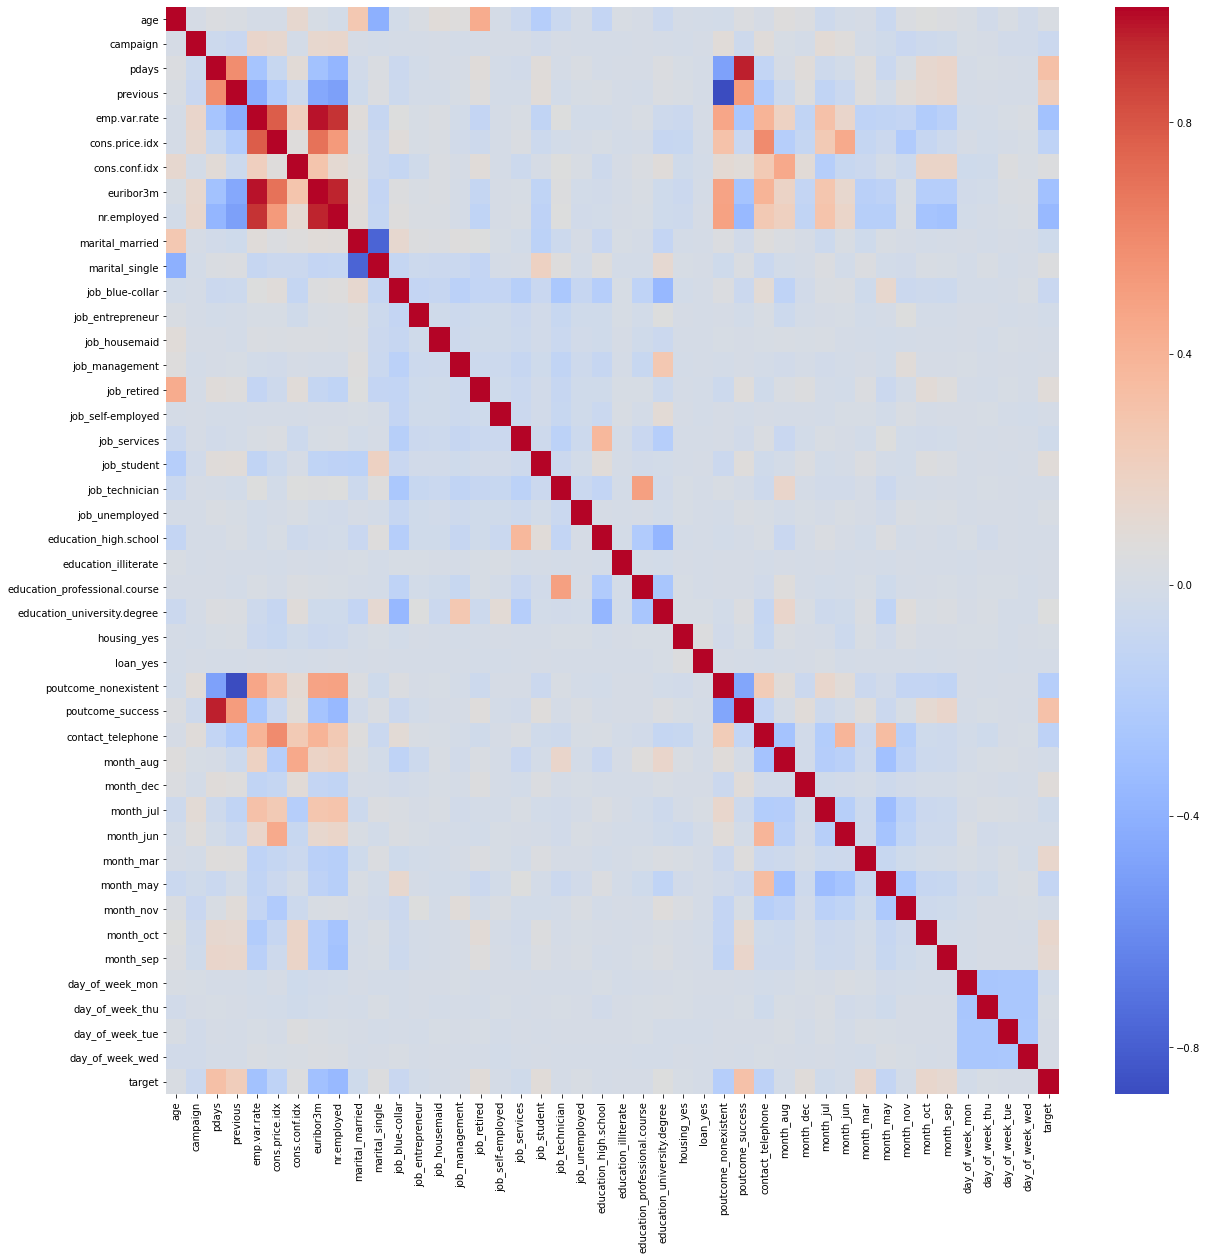

In [29]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(bank_i.corr(method='pearson'), annot=False, cmap='coolwarm')

In [712]:
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False


In [775]:
selected_columns = bank_i.columns[columns]

In [790]:
np.setdiff1d(bank_i.columns,selected_columns)

array(['euribor3m', 'nr.employed', 'poutcome_nonexistent',
       'poutcome_success', 'target'], dtype=object)

Highest correlation of features with target

In [794]:
corr['target'].nlargest(10)

target                  1.000000
nr.employed             0.347487
pdays                   0.318845
poutcome_success        0.310748
euribor3m               0.300511
emp.var.rate            0.292162
previous                0.221686
poutcome_nonexistent    0.184623
month_mar               0.142910
contact_telephone       0.141428
Name: target, dtype: float64

We can see that only 'euribor3m', 'nr.employed' are highly correlated with emp.var.rate while 'poutcome_nonexistent' and 'poutcome_success' are highly correlated with 'pdays'.
However, these features have high correlation with target as well. Hence we do not drop the columns and move to other feature selection methods.

#### Logistic regression coefficients and p-value test

In [838]:
X['Intercept']= 1
logistic_ml=sm.Logit(y,X)
logistic_coef=logistic_ml.fit()

Optimization terminated successfully.
         Current function value: 0.274495
         Iterations 9


In [839]:
result=logistic_coef.summary()
results_as_html = result.tables[1].as_html()
result_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
fs1=result_df.loc[result_df['P>|z|']<0.05].index

In [494]:
len(fs1)

20

In [374]:
bank_fs1=bank_i[fs1]

In [797]:
X_train_fs1,X_test_fs1,y_train,y_test=split_test_train(bank_fs1)

In [798]:

os_data_X_fs1, os_data_y_fs2 = os.fit_sample(X_train_fs1, y_train_fs1)

### Using tree based method

In [48]:

etc= ExtraTreesClassifier()
etc.fit(X,y)

ExtraTreesClassifier()

In [49]:
etc.fit(os_data_X,os_data_y)

ExtraTreesClassifier()

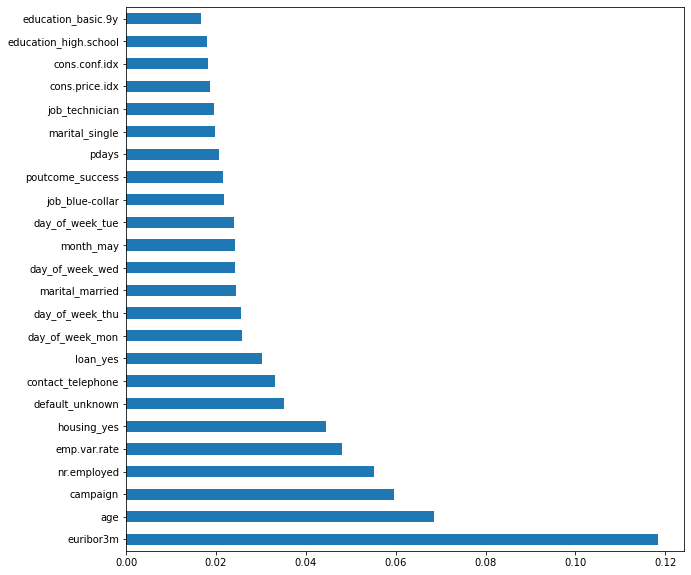

In [50]:
feat_importances = pd.Series(etc.feature_importances_, index=X.columns)
feat_importances.nlargest(24).plot(kind='barh',figsize=(10,10))
feature_importance_df = pd.DataFrame(data =feat_importances , index = X.columns, columns=['coefficient_values'])


In [829]:
for item in feature_importance_df['coefficient_values'].nlargest(24).index:
    print(item)

euribor3m
age
housing_yes
campaign
nr.employed
emp.var.rate
contact_telephone
marital_married
loan_yes
day_of_week_mon
month_may
day_of_week_wed
day_of_week_thu
education_high.school
education_university.degree
marital_single
pdays
day_of_week_tue
cons.price.idx
job_blue-collar
cons.conf.idx
poutcome_nonexistent
job_technician
poutcome_success


 Since most important features fall above the threshold of 0.015, we select the feature importance threshold as 0.015

In [51]:
m = SelectFromModel(etc, prefit=True,threshold=0.015 )
X_fs2 = m.transform(os_data_X)
X_test_fs2=m.transform(X_test)

In [52]:
X_fs2.shape

(51166, 27)

24 features have been selected from 41 using tree-based methods

### Model Building

We analyze the data using three models: Logistic regression, Decision Trees and Random Forests

In [41]:
def evaluate_model(X_train,y_train,X_test,model):
    
    """Function to train the model and print the evaluation results"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Classification Report')
    print(classification_report(y_test,y_pred))
    print(f'accuracy score:{accuracy_score(y_test,y_pred):0.3f}')
    print(f'precision:{precision_score(y_true=y_test,y_pred=y_pred):0.3f}')
    print(f'recall:{recall_score(y_true=y_test,y_pred=y_pred):0.3f}')
    print(f'F1:{f1_score(y_true=y_test,y_pred=y_pred):0.3f}')
    confmat=pd.DataFrame(confusion_matrix(y_test,y_pred),index=['True[0]','True[1]'],columns=['Predict[0]','Predict[1]'])
    print(confmat)
    skplt.metrics.plot_roc(y_test,model.predict_proba(X_test),plot_micro=False)
    plt.show()
    
    

### Logistic regression

First, we train the model using logistic regression

In [43]:
logreg=LogisticRegression() ## default model

C:\Users\aparn\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Classification Report
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.68      0.24      0.35      1392

    accuracy                           0.90     12357
   macro avg       0.80      0.61      0.65     12357
weighted avg       0.88      0.90      0.88     12357

accuracy score:0.902
precision:0.681
recall:0.236
F1:0.351
         Predict[0]  Predict[1]
True[0]       10811         154
True[1]        1063         329


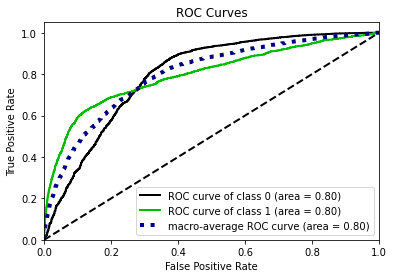

In [44]:
evaluate_model(X_train,y_train,X_test,logreg) # train with imalanced data

Use grid search to find optimum parameters

In [411]:
logreg_cv=GridSearchCV(logreg,param_grid,cv=5)
logreg_cv.fit(os_data_X,os_data_y)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)


tuned hpyerparameters :(best parameters)  {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.900796448429177


In [46]:
logreg_gs=LogisticRegression(C= 0.08858667904100823, penalty ='l1', solver= 'liblinear')

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10965
           1       0.34      0.67      0.45      1392

    accuracy                           0.82     12357
   macro avg       0.64      0.75      0.67     12357
weighted avg       0.88      0.82      0.84     12357

accuracy score:0.816
precision:0.338
recall:0.666
F1:0.449
         Predict[0]  Predict[1]
True[0]        9152        1813
True[1]         465         927


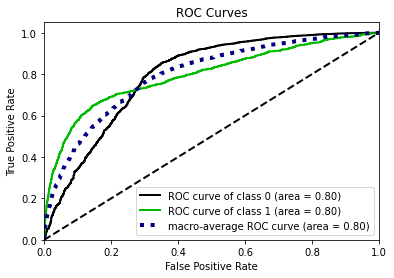

In [47]:
evaluate_model(os_data_X,os_data_y,X_test,logreg_gs)

#### Evaluating feature selected data

#### 1) LR coefficient based

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     10434
           1       0.29      0.63      0.40      1300

    accuracy                           0.79     11734
   macro avg       0.62      0.72      0.63     11734
weighted avg       0.87      0.79      0.82     11734

accuracy score:0.788
precision:0.291
recall:0.632
F1:0.398
         Predict[0]  Predict[1]
True[0]        8430        2004
True[1]         479         821


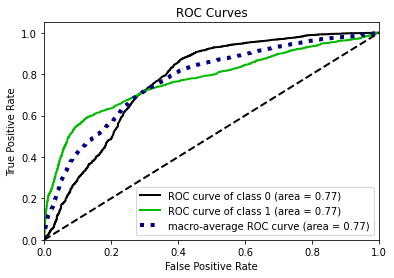

In [804]:
evaluate_model(os_data_X_fs1, os_data_y,X_test_fs1,logreg) # with oversampled data

#### 2) With tree based method

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10965
           1       0.32      0.67      0.43      1392

    accuracy                           0.80     12357
   macro avg       0.64      0.75      0.66     12357
weighted avg       0.88      0.80      0.83     12357

accuracy score:0.804
precision:0.322
recall:0.670
F1:0.435
         Predict[0]  Predict[1]
True[0]        9000        1965
True[1]         459         933


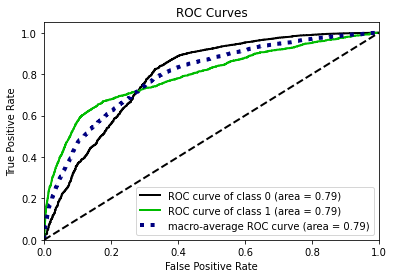

In [54]:
evaluate_model(X_fs2,os_data_y,X_test_fs2,logreg_gs)

### Decision tree classifier

In [764]:
param_grid = {'criterion':['gini','entropy'],'max_depth':list(range(1,30)),'max_leaf_nodes': list(range(2, 100))}
Grid_Search_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, verbose=1, cv=3) # grid search

In [470]:
dt_Search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9604 candidates, totalling 28812 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 28812 out of 28812 | elapsed: 28.6min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...]},
             verbose=1)

In [445]:
dt_Search_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=16,
                       random_state=1)

In [60]:
tree1=DecisionTreeClassifier()

In [765]:
dt_Search_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, verbose=1, cv=2,scoring='roc_auc')
dt_Search_cv1.fit(os_data_X, os_data_y) #grid search on resampled data

Fitting 2 folds for each of 5684 candidates, totalling 11368 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11368 out of 11368 | elapsed: 24.2min finished


GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...]},
             scoring='roc_auc', verbose=1)

In [766]:
Grid_Search_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=18, max_leaf_nodes=99,
                       random_state=1)

In [55]:
tree2=DecisionTreeClassifier(criterion='entropy', max_depth=18, max_leaf_nodes=99,
                       random_state=1)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10434
           1       0.63      0.24      0.35      1300

    accuracy                           0.90     11734
   macro avg       0.77      0.61      0.65     11734
weighted avg       0.88      0.90      0.88     11734

accuracy score:0.901
precision:0.634
recall:0.244
F1:0.352
         Predict[0]  Predict[1]
True[0]       10251         183
True[1]         983         317


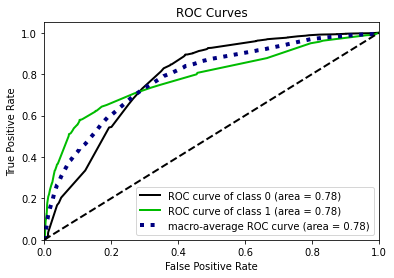

In [754]:
evaluate_model(X_train,y_train,X_test,tree1) # Imbalanced data

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     10965
           1       0.32      0.37      0.34      1392

    accuracy                           0.84     12357
   macro avg       0.62      0.63      0.62     12357
weighted avg       0.85      0.84      0.84     12357

accuracy score:0.839
precision:0.316
recall:0.369
F1:0.341
         Predict[0]  Predict[1]
True[0]        9852        1113
True[1]         878         514


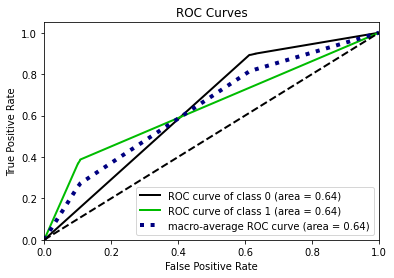

In [62]:
evaluate_model(os_data_X,os_data_y,X_test,tree1) #resampled data

### Random Forest Classifier

In [63]:
forest_param={'criterion':['gini','entropy'],'n_estimators' : list(range(10,101,10)),'max_features' : list(range(6,32,5))}
forest_search_cv = GridSearchCV(RandomForestClassifier(random_state=1), forest_param, verbose=1, cv=3,scoring='roc_auc')

In [64]:
forest_search_cv.fit(os_data_X, os_data_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 34.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [6, 11, 16, 21, 26, 31],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='roc_auc', verbose=1)

In [772]:
forest_search_cv.best_estimator_

RandomForestClassifier(max_features=6, random_state=1)

In [773]:
f1=RandomForestClassifier(max_features=6, random_state=1)

In [812]:
forest_search_cv1.fit(os_data_X,os_data_y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 25.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [6, 11, 16, 21, 26, 31],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='roc_auc', verbose=1)

In [814]:
forest_search_cv1.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=6, random_state=1)

In [815]:
f2=RandomForestClassifier(criterion='entropy', max_features=6, random_state=1)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10434
           1       0.54      0.27      0.36      1300

    accuracy                           0.89     11734
   macro avg       0.73      0.62      0.65     11734
weighted avg       0.87      0.89      0.88     11734

accuracy score:0.893
precision:0.536
recall:0.266
F1:0.356
         Predict[0]  Predict[1]
True[0]       10135         299
True[1]         954         346


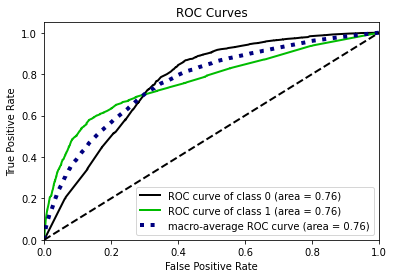

In [774]:
evaluate_model(X_train,y_train,X_test,f1) #imbalanced data

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10434
           1       0.47      0.35      0.40      1300

    accuracy                           0.89     11734
   macro avg       0.70      0.65      0.67     11734
weighted avg       0.87      0.89      0.88     11734

accuracy score:0.885
precision:0.474
recall:0.346
F1:0.400
         Predict[0]  Predict[1]
True[0]        9935         499
True[1]         850         450


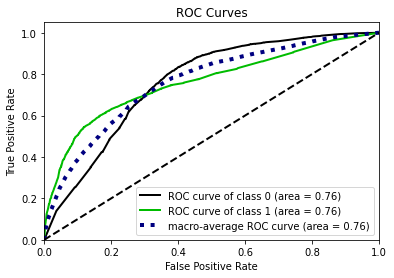

In [817]:
evaluate_model(os_data_X,os_data_y,X_test,f2) # resampled data